In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.svm import SVC

from darwin.config import (
    PROCESSED_DATA_DIR, 
    RANDOM_STATE, 
    CRITERION, 
    MAX_DEPTH, 
    CLASS_WEIGHT, 
    FEATURE_NUM
)

2025-04-06 17:22:52.562 | INFO     | darwin.config:<module>:11 - PROJ_ROOT path is: /Users/eduardoduarte/Projects/refactor-darwin/darwin


In [2]:
input_path = PROCESSED_DATA_DIR / 'preprocessed_data.csv'

In [3]:
df = pd.read_csv(input_path)

In [4]:
def select_feature_imp(df: pd.DataFrame, n: int) -> list[str]:
    """
    Given a DataFrame, returns the n most important features based on the 
    feature_importance_ of a RandomForestClassifier
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    # Splits the target and the features
    X = df.drop("class", axis='columns')
    y = df["class"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    
    # Train the Forest
    forest = RandomForestClassifier(n_estimators=100,
                                random_state=RANDOM_STATE,
                                criterion=CRITERION,
                                max_depth=MAX_DEPTH,
                                class_weight=CLASS_WEIGHT)
    forest.fit(X, y)

    # TODO: Run permutation importance to select most important features
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
    )
    
    # Get the feature importance
    feature_imp = pd.Series(forest.feature_importances_, index=X.columns)
    feature_imp = feature_imp.sort_values(ascending=False)

    selected_features = feature_imp.head(n).index.tolist()

    return selected_features

In [13]:
def select_anova(df: pd.DataFrame, n: int, function) -> list[str]:
    """
    Given a DataFrame, returns the n most important features based on the 
    ANOVA F-Value from SelectKBest
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    # Splits the target and the features
    X = df.drop("class", axis='columns')
    y = df["class"]

    # Fit the selector to the data
    selector = SelectKBest(function, k=n)
    selector.fit(X, y)

    # Get the selected features with highest f-value
    selected_indices = np.argsort(selector.scores_)[::-1][:n]
    selected_features = X.columns[selected_indices].tolist()
    
    return selected_features



In [6]:
def select_rfe(df: pd.DataFrame, n: int) -> list[str]:
    """
    Given a DataFrame, returns the n most important features selected
    by Recursive Feature Elimination with a Support Vector Classifier
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    # Splits the target and and features
    X = df.drop("class", axis='columns')
    y = df["class"]

    # Fit the selector to the data
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=n, step=1)
    selector = selector.fit(X, y)

    selected_features = X.columns[selector.support_].tolist()

    return selected_features

In [ ]:
from collections import Counter

counter = Counter(select_anova(df, FEATURE_NUM, f_classif) + select_feature_imp(df, FEATURE_NUM) + select_rfe(df, FEATURE_NUM))
print(counter)

Counter({'total_time9': 3, 'total_time15': 3, 'total_time3': 2, 'mean_speed_in_air17': 2, 'gmrt_in_air17': 2, 'air_time15': 2, 'gmrt_in_air7': 1, 'mean_gmrt7': 1, 'disp_index23': 1, 'mean_speed_in_air7': 1, 'paper_time9': 1, 'air_time16': 1, 'mean_gmrt17': 1, 'disp_index22': 1, 'total_time16': 1, 'total_time13': 1, 'mean_acc_in_air17': 1, 'gmrt_on_paper17': 1, 'mean_jerk_in_air17': 1, 'mean_speed_in_air25': 1, 'mean_speed_in_air23': 1, 'total_time23': 1, 'air_time23': 1, 'air_time17': 1, 'total_time6': 1, 'total_time17': 1, 'paper_time17': 1, 'total_time8': 1, 'air_time22': 1, 'paper_time23': 1, 'air_time5': 1, 'paper_time22': 1, 'total_time22': 1, 'total_time7': 1, 'num_of_pendown19': 1, 'pressure_mean5': 1, 'mean_jerk_in_air2': 1, 'gmrt_on_paper3': 1, 'disp_index4': 1, 'pressure_var5': 1, 'disp_index8': 1, 'mean_jerk_on_paper8': 1, 'gmrt_on_paper10': 1, 'paper_time12': 1, 'mean_acc_in_air13': 1, 'num_of_pendown14': 1, 'max_y_extension19': 1, 'pressure_var19': 1, 'paper_time20': 1, 'd

In [ ]:
feature_imp = df[select_feature_imp(df, FEATURE_NUM)]
anova = df[select_anova(df, FEATURE_NUM, f_classif)]
rfe = df[select_rfe(df, FEATURE_NUM)]

In [9]:
print(feature_imp.columns)
print(anova.columns)
print(rfe.columns)

Index(['total_time23', 'total_time15', 'air_time15', 'air_time23',
       'air_time17', 'total_time6', 'total_time17', 'paper_time17',
       'total_time3', 'total_time8', 'air_time22', 'paper_time23', 'air_time5',
       'paper_time22', 'total_time22', 'total_time7', 'num_of_pendown19',
       'total_time9', 'pressure_mean5', 'mean_speed_in_air17'],
      dtype='object')
Index(['gmrt_in_air7', 'mean_gmrt7', 'disp_index23', 'mean_speed_in_air7',
       'paper_time9', 'air_time16', 'mean_gmrt17', 'total_time9',
       'disp_index22', 'total_time3', 'total_time16', 'total_time13',
       'mean_speed_in_air17', 'mean_acc_in_air17', 'gmrt_on_paper17',
       'mean_jerk_in_air17', 'total_time15', 'mean_speed_in_air25',
       'gmrt_in_air17', 'mean_speed_in_air23'],
      dtype='object')
Index(['mean_jerk_in_air2', 'gmrt_on_paper3', 'disp_index4', 'pressure_var5',
       'disp_index8', 'mean_jerk_on_paper8', 'total_time9', 'gmrt_on_paper10',
       'paper_time12', 'mean_acc_in_air13', 'num_

In [10]:
assert feature_imp.shape[1] == FEATURE_NUM
assert anova.shape[1] == FEATURE_NUM
assert rfe.shape[1] == FEATURE_NUM

In [ ]:
import matplotlib.pyplot as plt

select_feature_imp(df, FEATURE_NUM)
select_anova(df, FEATURE_NUM, f_classif)
select_rfe(df, FEATURE_NUM)

['mean_jerk_in_air2',
 'gmrt_on_paper3',
 'disp_index4',
 'pressure_var5',
 'disp_index8',
 'mean_jerk_on_paper8',
 'total_time9',
 'gmrt_on_paper10',
 'paper_time12',
 'mean_acc_in_air13',
 'num_of_pendown14',
 'air_time15',
 'total_time15',
 'gmrt_in_air17',
 'max_y_extension19',
 'pressure_var19',
 'paper_time20',
 'disp_index21',
 'gmrt_in_air23',
 'air_time24']

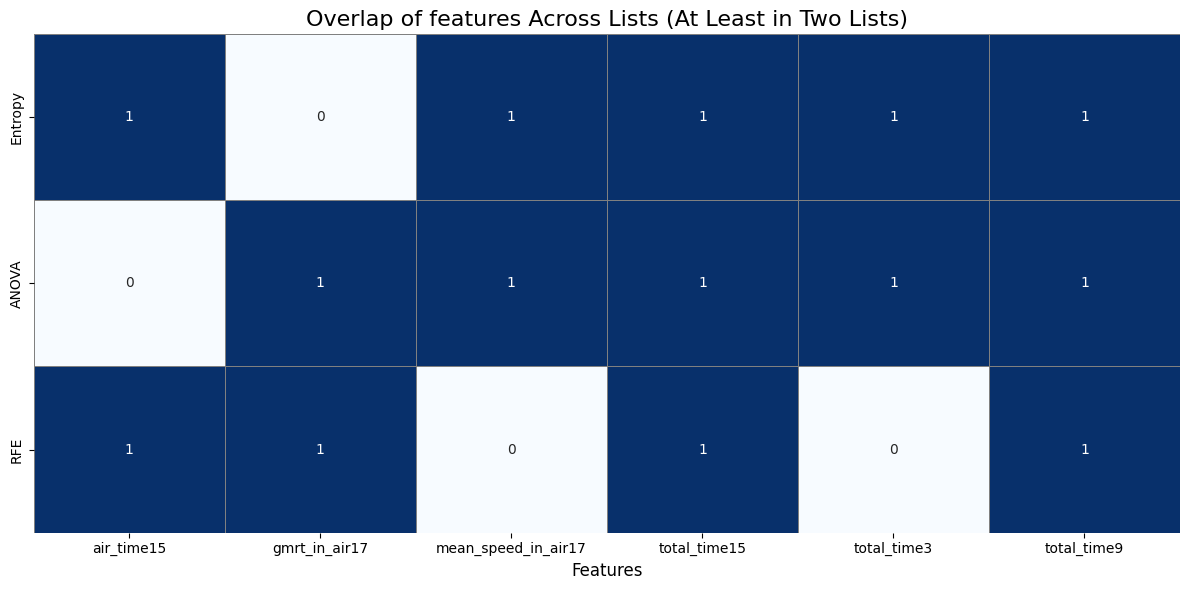

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import 

def plot_list_overlap(list_a, list_b, list_c):
    # Combine all unique strings from the lists
    all_strings = sorted(set(list_a + list_b + list_c))

    # Create a DataFrame to represent the presence of strings in each list
    data = {
        "Entropy": [1 if string in list_a else 0 for string in all_strings],
        "ANOVA": [1 if string in list_b else 0 for string in all_strings],
        "RFE": [1 if string in list_c else 0 for string in all_strings],
    }
    df = pd.DataFrame(data, index=all_strings)

    # Filter strings that exist in at least two lists
    df = df[df.sum(axis=1) >= 2]

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, cmap="Blues", cbar=False, linewidths=0.5, linecolor="gray", annot=True, fmt="d")

    # Customize the plot
    plt.title("Overlap of features Across Lists (At Least in Two Lists)", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    #plt.ylabel("Lists", fontsize=12)
    #plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    plt.show()

# Example lists
list_a = select_feature_imp(df, FEATURE_NUM)
list_b = select_anova(df, FEATURE_NUM)
list_c = select_rfe(df, FEATURE_NUM)

# Call the function to plot the overlap
plot_list_overlap(list_a, list_b, list_c)